<a href="https://colab.research.google.com/github/vardansaini/CMPUT-301-CustomList/blob/master/Linear_and_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Assignment 3 - Linear and Logistic Regression to Recognize Handwritten Digits [12 Marks]</h2>
<br>
<b>Due Date:</b> November 24 at 23.59.<br>
<b>What to submit:</b> An html version of this notebook (File -> Download as)

In this assignment you will implement Linear Regression and two variations of Logistic Regression for recognizing handwritten digits. We will use the MNIST data set to learn the classifiers. In the next cell we will download the data set and look at a few images. You will have to install tensorflow to download the data set from the code. You should be able to install it with:

<i>pip install tensorflow</i>

Let one of the instructors know if that does not work for you. 

<b>Warning:</b> This assignment requires that you perform operations with matrices in Numpy (e.g., multiplication and summation of the column vectors of a matrix). You should discover by yourself how to use the operations needed to complete the assignment. Numpy's documentation can be a good resource: https://numpy.org/doc/stable/

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


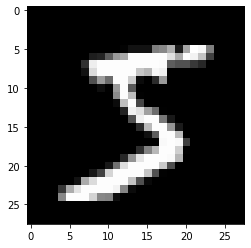

(60000,)
Label:  5


In [2]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

def plot_digit(image):
    """
    This function receives an image and plots the digit. 
    """
    plt.imshow(image, cmap='gray')
    plt.savefig('digit2')
    plt.show()

# The x variables contain the images of handwritten digits the y variables contain their labels indicating 
# which digit is in the image. We will see an example of image and label shortly. We have two data sets here:
# training and test sets. The idea is that we use the training set to learn the function and then we evaluate 
# the system on images the model did not see during training. This is to simulate the scenario in which we build 
# a system and we use it in the wild, where people write new digits and we would like our system to accurately 
# recognize them.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Each image is of size 28x28 and the training data set has 60,000 images
# the shape of x_train should then be (60000, 28, 28).
print(x_train.shape)

# Let's take a look at the first training instance. The image shows the digit 5. 
# Feel free to change the index of x_train to see other images. 
plot_digit(x_train[0])

# The y_train structure has shape 60,0000, with one entry for each image. The value of the first
# entry of y_train should be a five, indicating that the first image is of a 5.
print(y_train.shape)
print('Label: ', y_train[0])

In [3]:
# Instead of using all 60,000 images, we will use 20,000 in our experiments to speed up training.
training_size = 20000

# We will flatten the images to make our implementation easier. Instead of providing 
# an image of size 28x28 as input, we will provide a vector of size 784, with one entry 
# for each pixel of the image. We will also normalize the values in the images. The pixels
# values in the images vary from 0 to 255. We normalize them to avoid overflow during training. 
# Normalization also helps training because the optimization landscape is friendiler to gradient 
# descent once the input values are normalized. Studying the effects of the input values in the
# optimization landscape is outside the scope of this course. 
images, labels = (x_train[0:training_size].reshape(training_size, 28*28) / 255, y_train[0:training_size])

# The flattened images will be kept as column vectors in the matrix images
images = images.T
print('Shape of flattned images: ', images.shape)

# Here we apply the same transformations described above on the test data. 
images_test = x_test.reshape(x_test.shape[0], 28*28) / 255
images_test = images_test.T

Shape of flattned images:  (784, 20000)


<h3>Training Linear and Logistic Regression</h3>

We will train one function $h_{w_i}$ for each digit $i$, which will be parameterized by a vector $w_i$ and a scalar $b_i$. The vector $w_i$ will contain one entry for each pixel in the flattened image. That way, if an image $x$ contains the digit $i$, then the hypothesis $h_{w_i}(x)$ should produce a number close to $1$; the operation should produce a number close to $0$ if image $x$ does not contain digit $i$. 

$h_{w_i}$ is defined as follows for Linear Regression :

\begin{equation*}
h_{w_i} = w_i \cdot x + b
\end{equation*}

While it is defined as follows for Logistic Regression:

\begin{equation*}
h_{w_i} = g(w_i \cdot x + b)\,.
\end{equation*}
where $g$ is the logistic function $\frac{1}{1 + e^{-z}}$.

Given an image $x$, our model predicts digit $i$ for the largest value returned by $h_{w_i}$ for all $i$. For example, if we pass the first image of the training data x_train[0] to the model, then the model will predict the digit 5 correctly if the output of the functions $h_{w_i}$ are similar to the following (these are made-up numbers to illustrate the procedure).

\begin{align*}
h_{w_0} &= 0.1 \\
h_{w_1} &= 0.01 \\
h_{w_2} &= 0.05 \\
h_{w_3} &= 0.25 \\
h_{w_4} &= 0.40 \\
h_{w_5} &= 0.95 \\
h_{w_6} &= 0.80 \\
h_{w_7} &= 0.12 \\
h_{w_8} &= 0.71 \\
h_{w_9} &= 0.01 \\
\end{align*}

Since $h_{w_5}$ is the largest value, the model will predict that the image is of the digit 5.

We will use the training data (variables images and labels) to discover vectors $w_i$ and scalars $b_i$ that classify most of the training data correctly. This will be achieved by defining an error function and then applying gradient descent to minimize the error. We will adjust the values of $w_i$ and $b_i$ to reduce the error for each function $h_{w_i}$. 

Let $y$ be the label of an image $x$ for a specific function $h_{w_i}$. $y = 0$ if $x$ does not contain the digit $i$ and $y = 1$ otherwise. We will use the Mean Squared Error (MSE) loss function $J(w_i)$ for Linear Regression and one of the versions of Logistic Regression. MSE is defined as follows, where $m$ is the number of training instances. 
\begin{equation*}
J(w_i) = \frac{1}{2m} \sum_{x, y} (h_{w_i}(x) - y)^2
\end{equation*}
As an example, if $h_{w_i}(x) = 0.95$ for an image that does not contain digit $i$, then the error for this particular image will be $(0.95 - 0)^2 = 0.9025$; if $h_{w_i}(x) = 0$, then the error would have been zero for this instance. The positive error informs gradient descent that the values of $w_i$ need to be adjusted to reduce the error.  

<h3>Gradient Descent</h3>

We will initialize the values of $w_i$ with random values close to zero (this is already implemented for you) and $b$ with zeros and then adjust them according to gradient descent. 

Let $w_{i, j}$ be the $j$-th value of the vector $w_i$ for digit $i$. The value of $w_{i, j}$ and $b_i$ will be modified according to gradient descent (see equations below), where $\alpha$ is a small value indicating the size of the step performed by gradient descent. Recall from the lectures that if $\alpha$ is large gradient descent might fail to find the minimum of the error function. We will use $\alpha = 0.05$ in our experiments. 

Gradient descent uses the two equations below for Linear Regression and the two versions of Logistic Regression you will implement. 

\begin{align*}
w_{i, j} &= w_{i, j} - \alpha \frac{\partial J(w_i)}{\partial w_{i, j}} \text{ for all }j \\
b &= b - \alpha \frac{\partial J(w_i)}{\partial b}
\end{align*}

If implemented correctly, the equations above finds values of $w_i$ and $b_i$ that correctly classify at least 85\% of the test data. The problem with the approach described is that we need to implement 10 different functions, one for each digit. This is not only time consuming but also computationally expensive. Instead, we will discuss a vectorized version of the algorithm described above. 

<h3> Vectorized Implementation </h3>

In our vectorized implementation the model will produce a vector as output, with one entry for each digit. This way we will not need to implement one function $h_{w_i}$ for each digit, we will implement a single function $h_{W}$ for all digits, where $W$ is a matrix containing all vectors $w_i$ as row vectors. In addition to the matrix $W$, we will use a vector $B$ with one entry for each digit. The input images will be provided as a matrix $X$ with one flattened image in each column of $X$. 

The labels will also be provided as a matrix $Y$ of shape $(10, m)$, where $m$ is the number of instances in the training set. Each column of $Y$ is a one-hot vector (i.e., a vector with one entry equals $1$ and all other entries equal $0$). The entry with value of $1$ in a one-hot vector indicates the digit of the image. 

Here are all matrices we will use in our vectorized representation.

\begin{align*}
X =& 
 \begin{bmatrix}
 p_{0,0} &  p_{0, 1} & \cdots &  p_{0, m-1} \\
 p_{1, 0} &  p_{1,1} & \cdots &  p_{1, m-1} \\
 \cdots & \cdots & \cdots & \cdots \\
  p_{783, 0} &  p_{783, 1} & \cdots &  p_{783, m-1} \\
\end{bmatrix} \\
W =& 
 \begin{bmatrix}
w_{0,0} & w_{0,1} & \cdots & w_{0,783} \\
w_{1,0} & w_{1,1} & \cdots & w_{1,783} \\
\cdots & \cdots & \cdots & \cdots \\
w_{9,0} & w_{9,1} & \cdots & w_{9,783} \\
\end{bmatrix} \\
B =& 
 \begin{bmatrix}
b_0 \\
b_1 \\
\cdots \\
b_9
\end{bmatrix} \\
Y =& 
 \begin{bmatrix}
 y_{0,0} &  y_{0, 1} & \cdots &  y_{0, m-1} \\
 y_{1, 0} &  y_{1,1} & \cdots &  y_{1, m-1} \\
 \cdots & \cdots & \cdots & \cdots \\
  y_{9, 0} &  y_{9, 1} & \cdots & y_{9, m-1} \\
\end{bmatrix} \\
\end{align*}

<h4>Forward Propagation</h4>

Using the matrices above we can predict the label of all instances in a data set by performing the operation $\hat{Y} = W.$dot$(X) + B$ for Linear Regression and the operation $\hat{Y} = g(W.$dot$(X) + B)$ for Logistic Regression. The largest number in each column of matrix $\hat{Y}$ will indicate the predicted label. 


<h4>Backward Propagation</h4>

Let $E = \hat{Y} - Y$ be the matrix with the pure errors. The gradients of the bias terms can be computed by adding all column vectors of $E$, while the gradients for the weights can be computed as $E.dot(X.T)$. The average value is computed by dividing the values obtained with the operations above by $m$. We can now apply Gradient Descent by making a small step in the opposite direction of the gradients. 

<h3>Linear Regression [2 Marks]</h3>

We will start by implementing Linear Regression. Most of the code is already provided below. Read the code carefully and implement what is missing. 

In [50]:
class LinearRegression:
    
    def __init__(self, x_train, y_train, x_test, y_test):
        """
        Constructor assumes a x_train matrix in which each column contains an instance.
        Vector y_train contains one integer for each instance, indicating the instance's label. 
        
        Constructor initializes the weights W and B, alpha, and a one-vector Y containing the labels
        of the training set. Here we assume there are 10 labels in the dataset. 
        """
        self._x_train = x_train
        self._y_train = y_train
        self._x_test = x_test
        self._y_test = y_test
        self._m = x_train.shape[1]
        
        self._W = np.random.randn(10, 784) * 0.01
        self._B = np.zeros((10, 1))
        self._Y = np.zeros((10, self._m))
        self._alpha = 0.05

        for index, value in enumerate(labels):
            self._Y[value][index] = 1
            
    def return_weights_of_digit(self, digit):
        """
        Returns the weights of the model for a given digit
        """
        return self._W[digit, :]
            
    def h_theta(self, X):
        """
        Computes the value of the hypothesis according to the linear regression rule
        """
        
        # Write the computation of the hypothesis for a given matrix X
        #print(X.shape)
        #print(self._W.shape)
    
        return np.add(np.dot(self._W, X), self._B)
    
    def train(self, iterations):
        """
        Performs a number of iterations of gradient descend equals to the parameter passed as input.
        
        Returns a list with the percentage of instances classified correctly in the training and in the test sets.
        """
        classified_correctly_train_list = []
        classified_correctly_test_list = []
        
        for i in range(iterations):
            # Write the following four lines of code for computing the value produced by the model (A)
            # The pure error for all training instances (pure_error)
            # And adjust the matrices self._W and self._B according to the gradient descent rule
            A = self.h_theta(self._x_train)    #trying to get image to be trained so model
            pure_error = np.subtract(self.h_theta(self._x_train), self._Y)
            self._W = self._W - ((self._alpha/self._m)*np.dot(pure_error, self._x_train.transpose())) 
            self._B = self._B - ((self._alpha/self._m)*np.sum(pure_error, axis=1, keepdims=True))

            if i % 100 == 0:
                classified_correctly = np.sum(np.argmax(A, axis=0) == np.argmax(self._Y, axis=0))
                percentage_classified_correctly = (classified_correctly / self._m) * 100
                classified_correctly_train_list.append(percentage_classified_correctly)
                
                Y_hat_test = self.h_theta(images_test)
                test_correct = np.count_nonzero(np.argmax(Y_hat_test, axis=0) == self._y_test)
                classified_correctly_test_list.append((test_correct)/len(self._y_test) * 100)
                
                print('Accuracy train data: %.2f' % percentage_classified_correctly)
        return classified_correctly_train_list, classified_correctly_test_list    

The code below will call the training procedure you have implemented for Linear Regression with 3,000 training iterations, which is the number of times the model will be adjusted with the 20,000 training instances. An iteration is often referred to as an epoch in the literature. 

In [51]:
lin_reg = LinearRegression(images, labels, images_test, y_test)
print('Training Linear Regression')
percentage_lin_reg_train, percentage_lin_reg_test = lin_reg.train(3000)

Training Linear Regression
Accuracy train data: 10.48
Accuracy train data: 84.41
Accuracy train data: 85.45
Accuracy train data: 85.78
Accuracy train data: 85.94
Accuracy train data: 86.00
Accuracy train data: 86.10
Accuracy train data: 86.11
Accuracy train data: 86.07
Accuracy train data: 86.06
Accuracy train data: 86.07
Accuracy train data: 86.11
Accuracy train data: 86.10
Accuracy train data: 86.11
Accuracy train data: 86.10
Accuracy train data: 86.11
Accuracy train data: 86.13
Accuracy train data: 86.09
Accuracy train data: 86.08
Accuracy train data: 86.07
Accuracy train data: 86.08
Accuracy train data: 86.06
Accuracy train data: 86.07
Accuracy train data: 86.08
Accuracy train data: 86.08
Accuracy train data: 86.09
Accuracy train data: 86.10
Accuracy train data: 86.11
Accuracy train data: 86.11
Accuracy train data: 86.11


<h3>Logistic Regression with MSE Loss [2 Marks]</h3>

Read carefully the code below and finish the implementation of Logistic Regression with the MSE loss function. 

In [8]:
class LogisticRegression:
    
    def __init__(self, x_train, y_train, x_test, y_test):
        """
        Constructor assumes a x_train matrix in which each column contains an instance.
        Vector y_train contains one integer for each instance, indicating the instance's label. 
        
        Constructor initializes the weights W and B, alpha, and a one-vector Y containing the labels
        of the training set. Here we assume there are 10 labels in the dataset. 
        """
        self._x_train = x_train
        self._y_train = y_train
        self._x_test = x_test
        self._y_test = y_test
        self._m = x_train.shape[1]
        
        self._W = np.random.randn(10, 784) * 0.01
        self._B = np.zeros((10, 1))
        self._Y = np.zeros((10, self._m))
        self._alpha = 0.05

        for index, value in enumerate(labels):
            self._Y[value][index] = 1
            
    def sigmoid(self, Z):
        """
        Computes the sigmoid value for all values in vector Z
        """
        # Write the computation of the sigmoid function for a given matrix Z
        return 1/(1+np.exp(-Z))

    def derivative_sigmoid(self, A):
        """
        Computes the derivative of the sigmoid for all values in vector A
        """
        # Write the derivative of the sigmoid function for a given value A produced by the sigmoid
        return np.multiply(A, (1-A))

    def h_theta(self, X):
        """
        Computes the value of the hypothesis according to the logistic regression rule
        """
        # Write the computation of the hypothesis for a given matrix X
        return np.add(np.dot(self._W, X), self._B)
    
    def return_weights_of_digit(self, digit):
        """
        Returns the weights of the model for a given digit
        """
        return self._W[digit, :]
    
    def train(self, iterations):
        """
        Performs a number of iterations of gradient descend equals to the parameter passed as input.
        
        Returns a list with the percentage of instances classified correctly in the training and in the test sets.
        """
        classified_correctly_train_list = []
        classified_correctly_test_list = []
        
        for i in range(iterations):
            # Write the following four lines of code for computing the value produced by the model (A)
            # The pure error for all training instances (pure_error)
            # And adjust the matrices self._W and self._B according to the gradient descent rule
            A = self.sigmoid(self.h_theta(self._x_train))
            pure_error = np.subtract(self.h_theta(self._x_train), self._Y)
            self._W = self._W - ((self._alpha/self._m)*np.dot(pure_error*self.derivative_sigmoid(A), np.transpose(self._x_train)))
            self._B = self._B - ((self._alpha/self._m)*np.sum(pure_error*self.derivative_sigmoid(A)))

            if i % 100 == 0:
                classified_correctly = np.sum(np.argmax(A, axis=0) == np.argmax(self._Y, axis=0))
                percentage_classified_correctly = (classified_correctly / self._m) * 100
                classified_correctly_train_list.append(percentage_classified_correctly)
                
                Y_hat_test = self.h_theta(images_test)
                test_correct = np.count_nonzero(np.argmax(Y_hat_test, axis=0) == self._y_test)
                classified_correctly_test_list.append((test_correct)/len(self._y_test) * 100)
                
                print('Accuracy train data: %.2f' % percentage_classified_correctly)
        return classified_correctly_train_list, classified_correctly_test_list   

Next, we will train Logistic Regression with the MSE loss function. 

In [16]:
log_reg = LogisticRegression(images, labels, images_test, y_test)
print('Training Logistic Regression (MSE)')
percentage_log_reg_train, percentage_log_reg_test = log_reg.train(3000)

Training Logistic Regression (MSE)
Accuracy train data: 10.47
Accuracy train data: 81.15
Accuracy train data: 83.37
Accuracy train data: 84.00
Accuracy train data: 84.49
Accuracy train data: 84.70
Accuracy train data: 84.90
Accuracy train data: 85.05
Accuracy train data: 85.12
Accuracy train data: 85.26
Accuracy train data: 85.27
Accuracy train data: 85.28
Accuracy train data: 85.31
Accuracy train data: 85.32
Accuracy train data: 85.39
Accuracy train data: 85.46
Accuracy train data: 85.50
Accuracy train data: 85.52
Accuracy train data: 85.51
Accuracy train data: 85.50
Accuracy train data: 85.50
Accuracy train data: 85.52
Accuracy train data: 85.51
Accuracy train data: 85.49
Accuracy train data: 85.50
Accuracy train data: 85.50
Accuracy train data: 85.52
Accuracy train data: 85.52
Accuracy train data: 85.48
Accuracy train data: 85.49


<h3>Logistic Regression with Cross Entropy Loss [3 Marks]</h3>

Read carefully the code below and finish the implementation of Logistic Regression with the Cross Entropy loss function. 

The Cross Entropy loss is defined as follows. 

\begin{equation*}
J(w_i) = - \bigg( \frac{1}{m} \sum_{x, y} y \ln(h_{w_i}(x)) + (1 - y) \ln(1 - h_{w_i}(x)) \bigg )
\end{equation*}

Recall that by moving from MSE to Cross Entropy the derivation of the gradients change. 

In [14]:
class LogisticRegressionCrossEntropy:
    
    def __init__(self, x_train, y_train, x_test, y_test):
        """
        Constructor assumes a x_train matrix in which each column contains an instance.
        Vector y_train contains one integer for each instance, indicating the instance's label. 
        
        Constructor initializes the weights W and B, alpha, and a one-vector Y containing the labels
        of the training set. Here we assume there are 10 labels in the dataset. 
        """
        self._x_train = x_train
        self._y_train = y_train
        self._x_test = x_test
        self._y_test = y_test
        self._m = x_train.shape[1]
        
        self._W = np.random.randn(10, 784) * 0.01
        self._B = np.zeros((10, 1))
        self._Y = np.zeros((10, self._m))
        self._alpha = 0.05

        for index, value in enumerate(labels):
            self._Y[value][index] = 1
            
    def sigmoid(self, Z):
        """
        Computes the sigmoid value for all values in vector Z
        """
        # Write the computation of the sigmoid function for a given matrix Z
        return 1/(1+np.exp(-Z))

    def derivative_sigmoid(self, A):
        """
        Computes the derivative of the sigmoid for all values in vector A
        """
        # Write the derivative of the sigmoid function for a given value A produced by the sigmoid
        return (1/self._m)*np.dot(A, np.transpose(self._x_train))

    def h_theta(self, X):
        """
        Computes the value of the hypothesis according to the logistic regression rule
        """
        # Write the computation of the hypothesis for a given matrix X
        return np.add(np.dot(self._W, X), self._B)
    
    def return_weights_of_digit(self, digit):
        """
        Returns the weights of the model for a given digit
        """
        return self._W[digit, :]
    
    def train(self, iterations):
        """
        Performs a number of iterations of gradient descend equals to the parameter passed as input.
        
        Returns a list with the percentage of instances classified correctly in the training and in the test sets.
        """
        classified_correctly_train_list = []
        classified_correctly_test_list = []
        
        for i in range(iterations):
            # Write the following four lines of code for computing the value produced by the model (A)
            # The pure error for all training instances (pure_error)
            # And adjust the matrices self._W and self._B according to the gradient descent rule
            A = self.sigmoid(self.h_theta(self._x_train))
            pure_error = np.subtract(self.h_theta(self._x_train), self._Y)
            self._W = self._W - (self._alpha*self.derivative_sigmoid(pure_error))
            self._B = self._B - ((self._alpha/self._m)*np.sum(pure_error, axis=1, keepdims=True))

            if i % 100 == 0:
                classified_correctly = np.sum(np.argmax(A, axis=0) == np.argmax(self._Y, axis=0))
                percentage_classified_correctly = (classified_correctly / self._m) * 100
                classified_correctly_train_list.append(percentage_classified_correctly)
                
                Y_hat_test = self.h_theta(images_test)
                test_correct = np.count_nonzero(np.argmax(Y_hat_test, axis=0) == self._y_test)
                classified_correctly_test_list.append((test_correct)/len(self._y_test) * 100)
                
                print('Accuracy train data: %.2f' % percentage_classified_correctly)
        return classified_correctly_train_list, classified_correctly_test_list   

Finally, we will train Logistic Regression with Cross Entropy loss. 

In [15]:
log_reg_cross = LogisticRegressionCrossEntropy(images, labels, images_test, y_test)
print('Training Logistic Regression (Cross Entropy)')
percentage_log_reg_cross_train, percentage_log_reg_cross_test = log_reg_cross.train(3000)

Training Logistic Regression (Cross Entropy)
Accuracy train data: 11.34
Accuracy train data: 84.34
Accuracy train data: 85.42
Accuracy train data: 85.80
Accuracy train data: 86.02
Accuracy train data: 86.02
Accuracy train data: 86.06
Accuracy train data: 86.10
Accuracy train data: 86.11
Accuracy train data: 86.11
Accuracy train data: 86.08
Accuracy train data: 86.09
Accuracy train data: 86.12
Accuracy train data: 86.13
Accuracy train data: 86.15
Accuracy train data: 86.09
Accuracy train data: 86.09
Accuracy train data: 86.13
Accuracy train data: 86.13
Accuracy train data: 86.13
Accuracy train data: 86.13
Accuracy train data: 86.14
Accuracy train data: 86.15
Accuracy train data: 86.16
Accuracy train data: 86.17
Accuracy train data: 86.17
Accuracy train data: 86.17
Accuracy train data: 86.19
Accuracy train data: 86.19
Accuracy train data: 86.18


The next two cells will plot the training and test accuracy across the learning iterations of gradient descent for the Logistic Regression methods. 

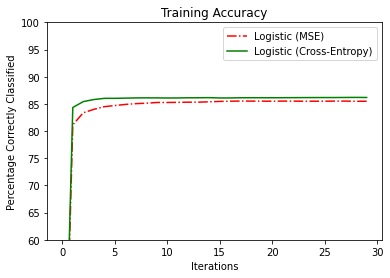

In [17]:
plt.xlabel('Iterations')
plt.ylabel('Percentage Correctly Classified')
plt.title('Training Accuracy')
plt.ylim([60, 100])
plt.plot(percentage_log_reg_train, 'r-.', label='Logistic (MSE)')
plt.plot(percentage_log_reg_cross_train, 'g-', label='Logistic (Cross-Entropy)')
plt.legend(loc='best')

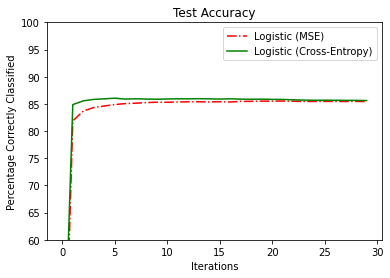

In [18]:
plt.xlabel('Iterations')
plt.ylabel('Percentage Correctly Classified')
plt.title('Test Accuracy')
plt.ylim([60, 100])
plt.plot(percentage_log_reg_test, 'r-.', label='Logistic (MSE)')
plt.plot(percentage_log_reg_cross_test, 'g-', label='Logistic (Cross-Entropy)')
plt.legend(loc='best')

<h4>Question 1 [2 Marks]</h4>

Why is one of the versions of Logistic Regression learning faster in terms of gradient descent iterations than the other? (write your answer in this cell by double-clicking it)

The cell below plots an image for each set of weights learned for each neuron in the Logistic Regression model (Cross Entropy). There are 784 weight-values for each neuron that are transformed into an image of size $28 \times 28$. 

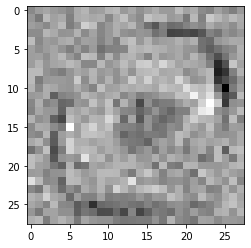

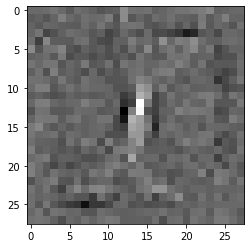

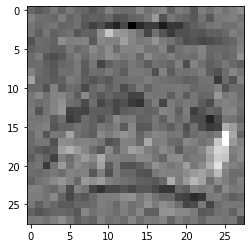

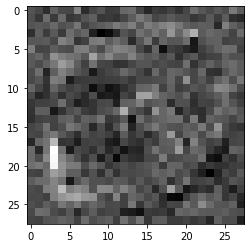

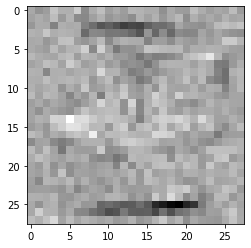

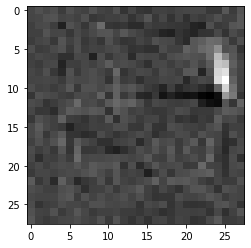

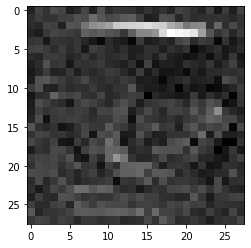

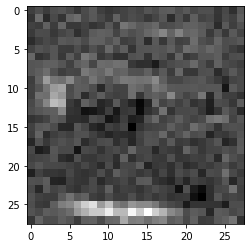

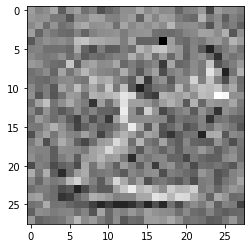

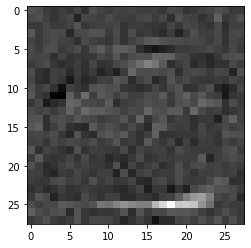

In [19]:
for i in range(0, 10):
    plot_digit(log_reg_cross.return_weights_of_digit(i).reshape(28, 28))

<h4>Question 2 [3 Marks]</h4>

Explain the images that were generated with the set of learned weights. Why do they look the way they do? (write your answer in this cell by double-clicking it)